In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Honesty(Function) Extraction 
- Dataset : facts_true_false.csv
- Model : (논문) ehartford/Wizard-Vicuna-30B-Uncensored /mistralai/Mistral-7B-Instruct-v0.1
- Model : (해볼만한 모델)'meta-llama/Meta-Llama-3-8B-Instruct'

In [1]:
import shutil

total, used, free = shutil.disk_usage("/")

print(f"총 용량: {total // (2**30)} GB")
print(f"사용 중: {used // (2**30)} GB")
print(f"남은 용량: {free // (2**30)} GB")  

총 용량: 467 GB
사용 중: 181 GB
남은 용량: 262 GB


In [2]:
import numpy as np
import torch
from tqdm import tqdm
from DataLoader import FunctionDatasetLoader
from transformers import AutoTokenizer,pipeline,AutoModelForCausalLM

model_id="mistralai/Mistral-7B-Instruct-v0.1"

tokenizer =AutoTokenizer.from_pretrained(
    model_id,
    padding_side="left",
    truncation_side ='left',
    legacy=False,
    device_map="auto"
)

if tokenizer.pad_token is None:
    tokenizer.pad_token=tokenizer.eos_token

model=AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.float16
)

model.config.pad_token_id=tokenizer.pad_token_id

print("모델 다운 완료")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

모델 다운 완료


In [85]:
from ReadingPipeline import RepPipeline
from DataLoader import FunctionDatasetLoader

user_tag="[INST]"
assistant_tag="[/INST]"
file_path="../data/facts_true_false.csv"
hidden_layers=list(range(1,model.config.num_hidden_layers+1))

data_loader=FunctionDatasetLoader(tokenizer=tokenizer,user_tag=user_tag,assistant_tag=assistant_tag)
dataset=data_loader.load_data(file_path=file_path)
train_inputs=dataset["train"]["data"]
train_labels=dataset["train"]["labels"]
test_inputs=dataset["test"]["data"]
test_labels=dataset["test"]["labels"]
print(f"Train data:{len(train_inputs)}")
print(f"Test data:{len(test_labels)}")



Train data:1024
Test data:1024


In [92]:
from ReadingPipeline import RepPipeline

func_reading=RepPipeline(model=model,tokenizer=tokenizer)
func_directions=func_reading.get_direction(
    train_inputs=train_inputs,
    train_labels=train_labels,
    hidden_layers=hidden_layers,
    rep_token=-1,
    batch_size=32,
    mode="comparing"
)
binary_results=func_reading.predict(
    test_inputs=test_inputs,
    test_labels=test_labels,
    hidden_layers=hidden_layers,
    rep_token=-1,
    batch_size=32,
    mode="binary"
)
comparing_results=func_reading.predict(
    test_inputs=test_inputs,
    test_labels=test_labels,
    hidden_layers=hidden_layers,
    rep_token=-1,
    batch_size=32,
    mode="comparing"
)

Extracting Hiddens:   0%|          | 0/32 [00:00<?, ?it/s]

Extracting Hiddens: 100%|██████████| 32/32 [00:04<00:00,  7.81it/s]


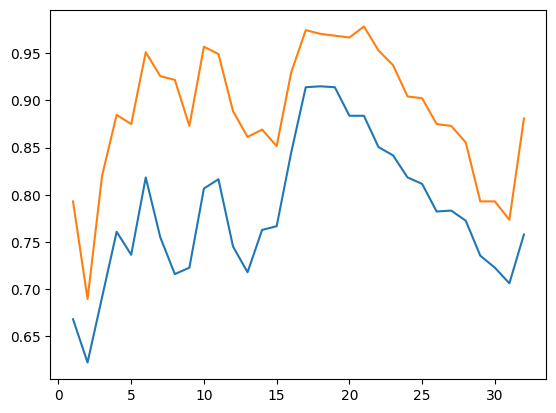

In [95]:
import matplotlib.pyplot as plt
plt.plot(hidden_layers, [binary_results[layer] for layer in hidden_layers])
plt.plot(hidden_layers, [comparing_results[layer] for layer in hidden_layers])